In [7]:
import os
from langgraph.prebuilt import create_react_agent
from langchain.agents import Tool
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings,ChatOpenAI
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import START,END,StateGraph
from typing import Annotated,TypedDict,Sequence
from langchain_core.messages import BaseMessage,HumanMessage,AIMessage
from langgraph.graph.message import add_messages

In [8]:
docs=WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/").load()
splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=50)
chunks=splitter.split_documents(docs)

embedding=OpenAIEmbeddings(model='text-embedding-3-small')
vector_store=FAISS.from_documents(chunks,embedding)
retriever=vector_store.as_retriever()

In [9]:
def retriever_tool_func(query:str) -> str:
    docs=retriever.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

In [20]:
retriever_tool=Tool(
    name="RAGRetriever",
    description="Use this tool to fetch relevant knowledge base info",
    func=retriever_tool_func
)
print(retriever_tool.name)

RAGRetriever


In [11]:
wiki_tool=WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
wiki_tool

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from '/home/bhupen/miniconda3/envs/agenticai_env/lib/python3.12/site-packages/wikipedia/__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))

In [12]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['OPENAI_API_KEY']=os.getenv('OPENAI_API_KEY')
llm=ChatOpenAI(model='gpt-4o-mini')

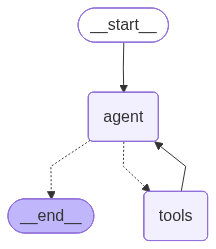

In [13]:
tools=[retriever_tool,wiki_tool]

react_node=create_react_agent(llm,tools)
react_node

In [14]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],add_messages]
    

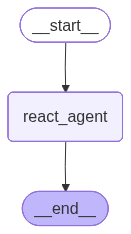

In [15]:
builder=StateGraph(AgentState)

builder.add_node("react_agent",react_node)
builder.set_entry_point("react_agent")
builder.add_edge("react_agent",END)

graph=builder.compile()
graph

In [17]:
if __name__=="__main__":
    user_question="What is an agent loop and how does wikipedia describe autonomous agents?"
    state={"messages":[HumanMessage(content=user_question)]}
    final_state=graph.invoke(state)

    print(f"Final answer: {final_state["messages"][-1].content}")

Final answer: ### What is an Agent Loop?

An "agent loop" typically refers to the cycle through which an autonomous agent interacts with its environment to perform tasks. The general process includes perceiving the environment, processing that information to make decisions, taking actions based on those decisions, and then receiving feedback from the environment to improve future actions. This loop allows the agent to continuously learn and adapt its behavior.

While the specific document didn't provide a detailed definition, this cyclical interaction is foundational in the design of intelligent agents, ensuring they can operate autonomously and effectively.

### Autonomous Agents as Described by Wikipedia

According to Wikipedia, an **autonomous agent** is an artificial intelligence (AI) system that can perform complex tasks independently. This category is a subset of intelligent agents, which are systems that perceive their environment and take actions autonomously to achieve specifi

### Tools Creation

In [18]:
import os
from typing import Annotated,Sequence,TypedDict
from langchain.agents import Tool
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings,ChatOpenAI
from langchain_community.document_loaders import WebBaseLoader,ArxivLoader,TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph,END
from langchain_core.messages import BaseMessage,HumanMessage
from langgraph.graph.message import add_messages

In [19]:
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x7feda69a4920>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7feda69a6fc0>, root_client=<openai.OpenAI object at 0x7feda69a5f40>, root_async_client=<openai.AsyncOpenAI object at 0x7feda69a4890>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'))

In [22]:
def make_retrieval_tool_text(file,name,desc):
    docs=TextLoader(file,encoding='utf-8').load()
    chunks=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=50).split_documents(docs)
    vector_store=FAISS.from_documents(chunks,OpenAIEmbeddings(model='text-embedding-3-small'))
    retriever=vector_store.as_retriever

    def tool_func(query:str)->str:
        print(f"Using tool: {name}")
        results=retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)
    
    return Tool(name=name,description=desc,func=tool_func)



wiki_tool=Tool(
    name="Wikipedia",
    description="Use this tool to fetch general world knowledge from wikipedia",
    func=WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
)


def arxiv_search(query:str) -> str:
    print("Searching Arxiv...")
    results=ArxivLoader(query).load()
    return "\n\n".join(doc.page_content[:1000] for doc in results[:2]) or "No papers found."

arxiv_tool=Tool(
    name="ArxivSearch",
    description="Use this tool to fetch recent academic papers on technical topics.",
    func=arxiv_search
)

In [23]:
internal_tool1=make_retrieval_tool_text(
    "internal_docs.txt",
    "InternalTechDocs",
    "Search internal tech documents for proprietary architecture and methods"
)
internal_tool1

Tool(name='InternalTechDocs', description='Search internal tech documents for proprietary architecture and methods', func=<function make_retrieval_tool_text.<locals>.tool_func at 0x7fed928a2200>)

In [24]:
internal_tool2=make_retrieval_tool_text(
    "research_notes.txt",
    "InternalResearchNotes",
    "Search internal research notes for experimental results and agent designs."
)
internal_tool2

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results and agent designs.', func=<function make_retrieval_tool_text.<locals>.tool_func at 0x7fed92f77ba0>)

In [25]:
tools=[wiki_tool,arxiv_tool,internal_tool1,internal_tool2]

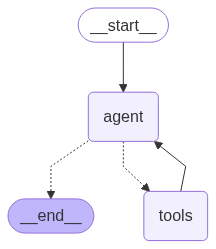

In [27]:
react_node=create_react_agent(llm,tools)
react_node

In [28]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],add_messages]

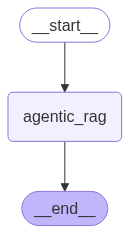

In [29]:
builder=StateGraph(AgentState)
builder.add_node("agentic_rag",react_node)
builder.set_entry_point("agentic_rag")
builder.add_edge("agentic_rag",END)

graph=builder.compile()
graph

In [34]:
query="what does research says about 'Ethical and Societal Considerations'?"
state={"messages":[HumanMessage(content=query)]}
result=graph.invoke(state)

print(f"Final Answer: {result["messages"][-1].content}")

Searching Arxiv...
Using tool: InternalResearchNotes
Searching Arxiv...
Using tool: InternalTechDocs
Final Answer: It seems there was an error while trying to retrieve academic papers and internal research notes on "Ethical and Societal Considerations." However, I can summarize some general points regarding this topic based on existing knowledge.

### Ethical and Societal Considerations

1. **Definition**: Ethical and societal considerations refer to the implications that policies, technologies, and scientific advancements have on individuals, communities, and societies as a whole. This includes moral dilemmas, social justice, and the impact of decisions on human well-being.

2. **Importance**: In research and practice, it is crucial to consider ethical and societal factors to ensure that developments are not only scientifically sound but also socially acceptable and beneficial. This helps prevent harm and promotes equity.

3. **Key Areas of Focus**:
   - **Informed Consent**: Ensuring